# Foreword

For the purpose of Data Science Special Syllabus Report, I am going to use the data from Robot Field for the year 2020. 

# Preprocessing

In [131]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import os
import datetime
from copy import copy
import pprint # pretty print
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

## Importing Data

In [132]:
path = './Data/'
list_data = os.listdir(path)
os.listdir(path)

['band',
 'download.png',
 'feature_importance_CatBoost Regressor.pdf',
 'feature_importance_CB.pdf',
 'feature_importance_GB.pdf',
 'feature_importance_RF.pdf',
 'heatmap.pdf',
 'raw',
 'Robot_2020_mean_fixed_rows.csv',
 'Robot_2020_median_fixed_rows.csv',
 'Robot_2020_stdev_fixed_rows.csv',
 'Robot_fixed_cols.csv']

In [133]:
import_data = []
import_files = ['Robot_2020_median_fixed_rows.csv']
for csv_data in tqdm(import_files, desc="Importing data", unit="files"):
    if os.path.isfile(os.path.join(path, csv_data)):
        df_name = csv_data[:-4]
        import_data.append(df_name)

        locals()[df_name] = pd.read_csv(path+csv_data)
        print(df_name, '=====', locals()[df_name].shape)
    

Importing data: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.14files/s]

Robot_2020_median_fixed_rows ===== (96, 114)


# Using the median fixed rows dataset

In [134]:
df = Robot_2020_median_fixed_rows.copy()

In [135]:
# Sowing date of the field
sowing = '200420'
maturity = '310720'
heading = '170620'

sowing_date = datetime.datetime.strptime(sowing, '%d%m%y').date()
maturity_date = datetime.datetime.strptime(maturity, '%d%m%y').date()
heading_date =datetime.datetime.strptime(heading, '%d%m%y').date()

In [136]:
# ToDo: Add check for duplicate columns in the df

general_col_names = ['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

# list_agg_df
yield_cols = ['GrainYield', 'Days2Heading', 'Days2Maturity']
id_cols_new = ['Plot_ID']

# Counter for location of column in columns list
loc = 0

# Dict for saving the name and location of the yield column
loc_yield_cols = {}

for cols in df.columns.tolist():
    for y_col in yield_cols:
        if not cols.find(y_col):
            loc_yield_cols[cols] = loc
            print(f'\"{cols}\" column in features_df seems like the yield column as it contains the text \"{y_col}\". It is located at location {loc}')
    loc += 1

yield_cols_found = list(loc_yield_cols.keys())
target_cols=yield_cols_found[0]

"GrainYield_180620" column in features_df seems like the yield column as it contains the text "GrainYield". It is located at location 9


In [137]:
df_aoc = df[id_cols_new+yield_cols_found]
# Renaming Grain_Yield Column #custom
df_aoc.columns = [df_aoc.columns[0]]+['GrainYield']
df_aoc.head(2)

,Plot_ID,GrainYield
0,1101,453.658537
1,1102,439.024390


## Filtering df for date that can be used

In [138]:
cols_blue = [x for x in df.columns if 'Blue_' in x]
dates = [x.split('_')[1] for x in cols_blue]
date_fmt = [datetime.datetime.strptime(x, '%d%m%y').date() for x in dates]
# dates
# len(date_fmt)
in_between_dates = []
for d in date_fmt:
    if d >= heading_date and d <= maturity_date:
        in_between_dates.append(d)
in_between_dates

[datetime.date(2020, 6, 18),
 datetime.date(2020, 6, 23),
 datetime.date(2020, 6, 24),
 datetime.date(2020, 6, 25),
 datetime.date(2020, 6, 29),
 datetime.date(2020, 7, 1),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 13),
 datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 22),
 datetime.date(2020, 7, 27),
 datetime.date(2020, 7, 30)]

In [139]:
temp_cols1 = [x for x in df.columns if not '040820' in x]
temp_cols2 = [x for x in temp_cols1 if not '120820' in x]
temp_cols3 = [x for x in temp_cols2 if not '180620' in x]

df_select = df[temp_cols3]
df_select.head(2)


,Plot_ID,Blue_230620,Green_230620,Red_230620,RedEdge_230620,NIR_230620,NDVI_230620,MTCI_230620,EVI_230620,Blue_240620,Green_240620,Red_240620,RedEdge_240620,NIR_240620,NDVI_240620,MTCI_240620,EVI_240620,Blue_250620,Green_250620,Red_250620,RedEdge_250620,NIR_250620,NDVI_250620,MTCI_250620,EVI_250620,Blue_290620,Green_290620,Red_290620,RedEdge_290620,NIR_290620,NDVI_290620,MTCI_290620,EVI_290620,Blue_010720,Green_010720,Red_010720,RedEdge_010720,NIR_010720,NDVI_010720,MTCI_010720,EVI_010720,Blue_070720,Green_070720,Red_070720,RedEdge_070720,NIR_070720,NDVI_070720,MTCI_070720,EVI_070720,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,EVI_130720,Blue_200720,Green_200720,Red_200720,RedEdge_200720,NIR_200720,NDVI_200720,MTCI_200720,EVI_200720,Blue_220720,Green_220720,Red_220720,RedEdge_220720,NIR_220720,NDVI_220720,MTCI_220720,EVI_220720,Blue_270720,Green_270720,Red_270720,RedEdge_270720,NIR_270720,NDVI_270720,MTCI_270720,EVI_270720,Blue_300720,Green_300720,Red_300720,RedEdge_300720,NIR_300720,NDVI_300720,MTCI_300720,EVI_300720
0,1101,0.031525,0.098336,0.042261,0.162172,0.634124,0.881080,-0.406316,-1.728818,0.018872,0.049369,0.024608,0.112616,0.402543,0.885614,3.262092,-1.065631,0.028579,0.065614,0.046904,0.121527,0.294172,0.724423,2.949702,-0.514457,0.002445,0.005291,0.002453,0.013643,0.042929,0.891991,2.608521,-0.102199,0.021905,0.051635,0.028147,0.142298,0.465755,0.885390,2.803551,-1.261239,0.026941,0.078043,0.059719,0.163123,0.365088,0.713755,1.996877,-0.638697,0.018340,0.067697,0.023631,0.246153,0.735899,0.937665,2.195285,-3.276678,0.024546,0.082166,0.051452,0.182917,0.459972,0.802431,2.067497,-0.988834,0.019306,0.066392,0.047035,0.176781,0.394213,0.787492,1.685444,-0.840385,0.025022,0.068829,0.069010,0.15343,0.289067,0.602283,1.577007,-0.419105,0.025994,0.058859,0.070486,0.190948,0.377660,0.675071,1.651821,-0.619201
1,1102,0.025550,0.084070,0.036522,0.161120,0.577145,0.886249,-0.457174,-1.621326,0.024412,0.054661,0.030559,0.117232,0.405762,0.860194,3.320230,-0.976404,0.032563,0.066505,0.050314,0.125360,0.285351,0.702292,3.120023,-0.466065,0.003207,0.005747,0.003020,0.013781,0.041950,0.866511,2.609107,-0.097302,0.028108,0.055910,0.035009,0.145149,0.458687,0.858816,2.861652,-1.100831,0.024079,0.078848,0.043090,0.169368,0.410774,0.809001,1.904274,-0.893868,0.019176,0.051398,0.030258,0.135311,0.361238,0.845886,2.162522,-0.858232,0.031326,0.091255,0.063361,0.189308,0.447530,0.757654,1.983066,-0.822572,0.026521,0.076623,0.059252,0.186323,0.388483,0.736908,1.595386,-0.705938,0.023936,0.071961,0.061892,0.16706,0.320667,0.670205,1.389728,-0.525876,0.035946,0.075253,0.089332,0.194962,0.356104,0.598632,1.530140,-0.460115


## ToDo: Identify Dates and index with problems

In [140]:
general_col_names

['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'EVI']

Wall time: 1.81 s


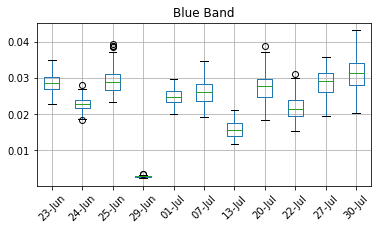

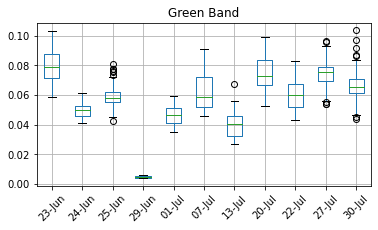

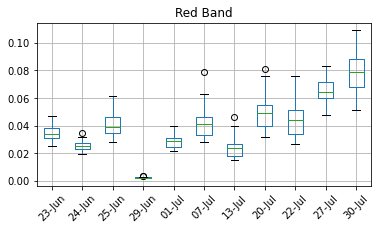

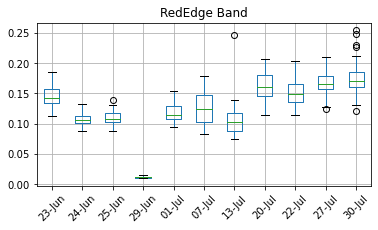

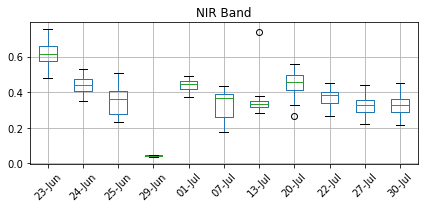

In [155]:
%%time

# base_indices = general_col_names[1:]
base_indices= [ 'Blue', 'Green', 'Red', 'RedEdge', 'NIR']

field_sample = ''
for col in base_indices:
    fig_size=(6,3)
    n_plot = 0
    fig, ax = plt.subplots(1,1, figsize=fig_size)
    plots = [ax]
    
    temp_df = pd.DataFrame()
    for cols in df_select.columns[1:]:
        # Adding required data to a temp dataframe
        if col+'_' in cols:
            date_str = cols.split('_')[1]
            date = datetime.datetime.strptime(date_str, '%d%m%y').date()
            col_name = date.strftime('%d-%b')+'_'+col
            temp_df[col_name] = df_select[cols]
    # Adding field plot to the subplots

    ax_n = plots[n_plot]
    x_labels = [date[:-(len(col)+1)] for date in temp_df.columns.tolist()]
    temp_df.boxplot(ax=ax_n)

    ax_n.set_xticklabels(x_labels, rotation=45)
    ax_n.set_title(field_sample+''+col+' Band')
    plt.savefig('Data/band/'+col+'.pdf',dpi=500, bbox_inches='tight')

    n_plot += 1
plt.tight_layout()

It looks like that the data from 29 June does not follow the trends of the data for several indices. So, it can be dropped.

## Delete data from dates with problems, i.e. are out of trend

In [12]:
temp_cols1 = [x for x in df_select.columns if not '290620' in x]
# temp_cols2 = [x for x in temp_cols1 if not '120820' in x]
# temp_cols3 = [x for x in temp_cols2 if not '180620' in x]
df_select = df_select[temp_cols1]
df_select.head(2)
df_select.shape

(96, 90)

# Integrating the data from different dates using simpsonian integration

In [13]:
from scipy.integrate import simps
from numpy import trapz

## Calculating AOC and creating new df with calculated values

In [14]:

for col_name in general_col_names[1:]:
    list_simp = []
    temp_cols = [x for x in df_select.columns if col_name+'_' in x]
    temp_dates = [datetime.datetime.strptime(date.split('_')[1], '%d%m%y').date() for date in temp_cols]
    days_sow = [(x-sowing_date).days for x in temp_dates]

    for sample in range(df_select.shape[0]):

        temp_entries= [df_select[x][sample] for x in temp_cols]
        list_simp.append(simps(temp_entries,days_sow))
#     print(temp_cols)

#     plt.plot(list_simp)
#     plt.show()
    df_aoc[col_name] = list_simp
df_aoc

<ipython-input-14-852067d104a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aoc[col_name] = list_simp


,Plot_ID,GrainYield,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,EVI
0,1101,453.658537,1.140449,3.289495,2.174728,7.145957,18.671901,31.860059,70.468431,-46.515493
1,1102,439.024390,1.162107,3.216190,2.130707,6.837899,16.790288,32.022578,68.874278,-35.169059
2,1103,409.756098,1.303988,3.406214,2.389348,6.903629,16.682318,30.841366,69.318976,-32.215940
3,1104,474.796748,1.188988,3.164827,2.124763,6.547565,16.298964,32.025119,72.659576,-32.965596
4,1105,411.382114,1.278810,3.296357,2.297247,6.898202,16.332953,31.226680,70.407240,-32.135993
...,...,...,...,...,...,...,...,...,...,...
91,1808,429.268293,1.237133,3.043614,2.077520,6.070051,15.419659,31.712191,66.352501,-30.321913
92,1809,414.634146,1.196637,2.983624,1.928795,5.675383,15.753819,32.444795,69.638629,-32.446815
93,1810,460.162602,1.286602,3.064071,2.106050,5.842421,15.347268,31.314367,69.046737,-30.114992
94,1811,443.902439,1.309689,3.102665,2.166354,6.061913,15.342692,31.347682,68.664876,-28.978802


# Data Trends Visualisation

## Correlation heatmap of indices with target

In [15]:

sns.diverging_palette(331, 129, as_cmap=True)


In [16]:
pal=['PRGn', 'PiYG', 'PuOr', 'RdBu','RdYlBu','RdYlGn','Spectral']

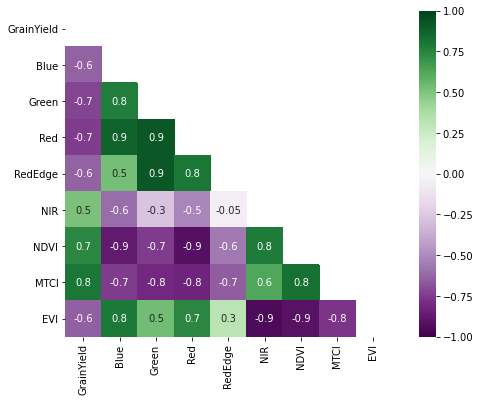

In [17]:
correlation = df_aoc.iloc[:,1:].corr()
matrix = np.triu(correlation)

plt.figure(figsize=(10,6))
sns.heatmap(correlation, cmap='PRGn', annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0 ,square=True, mask=matrix)
# plt.savefig('Data/heatmap.pdf',dpi=500, bbox_inches='tight')
plt.show()


# Model Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor


# Preparing data for ML

In [19]:
features_df = df_aoc.copy()
features_df.columns

Index(['Plot_ID', 'GrainYield', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR',
       'NDVI', 'MTCI', 'EVI'],
      dtype='object')

In [20]:
# ToDo: Add check for duplicate columns in the features_df

# list_agg_df
yield_cols = ['GrainYield', 'Days2Heading', 'Days2Maturity']
id_cols_new = ['Plot_ID']

# Counter for location of column in columns list
loc = 0

# Dict for saving the name and location of the yield column
loc_yield_cols = {}

for cols in features_df.columns.tolist():
    for y_col in yield_cols:
        if not cols.find(y_col):
            loc_yield_cols[cols] = loc
            print(f'\"{cols}\" column in features_df seems like the yield column as it contains the text \"{y_col}\". It is located at location {loc}')
    loc += 1

yield_cols_found = list(loc_yield_cols.keys())
target_cols=yield_cols_found[0]

"GrainYield" column in features_df seems like the yield column as it contains the text "GrainYield". It is located at location 1


In [21]:
#==============================================================================
# Initializing the comments to be appended to results
#==============================================================================

comments = []
comments.append('Median')
comments.append('EVI')
comments.append('Simpsonian Integration')
comments.append('Droped dates 040820, 120820, 290620')

In [22]:
#==============================================================================
# Split dataframe into data and target
#==============================================================================

temp_X = features_df.drop(columns = yield_cols_found+id_cols_new)
y = features_df[target_cols]
# y = features_df[target_cols].values.flatten()
comments.append('Drop Plot_ID.')
comments.append('GrainYield Target.')
X = temp_X.copy()


In [23]:
temp_X.head(2)

,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,EVI
0,1.140449,3.289495,2.174728,7.145957,18.671901,31.860059,70.468431,-46.515493
1,1.162107,3.216190,2.130707,6.837899,16.790288,32.022578,68.874278,-35.169059


## Declaring functions

In [35]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,3.5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], )
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.savefig('Data/feature_importance_'+model_type+'.pdf',dpi=500, bbox_inches='tight')
    display(fi_df)

# Predictions

In [ ]:
#==============================================================================
# Lasso
#==============================================================================
model = 
pipe = Pipeline(steps=[('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__selection' : ['cyclic','random']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

In [55]:
param=[x/10 for x in range(25,100)]
param=[x for x in range(0,1000, 100)]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    for rs in range(10):
        #==============================================================================
        # Create separate train/test splits
        #==============================================================================
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        #==============================================================================
        # Training best performing models
        #==============================================================================
        model = Lasso(alpha= 4.5)
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        R2.append(r2_score(y_test, y_pred))
    accuracy['R2'] = R2
    for k, s in accuracy.items():
        scores[pr]=(sum(s)/len(s))
scores

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


{1: 0.6165133338737417}

In [58]:
plot_feature_importance(model.feature_importances_,X_train.columns,'CatBoost Regressor')


AttributeError: 'Lasso' object has no attribute 'feature_importances_'

In [36]:
param = [int(x) for x in range(8, 25)]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    for rs in range(10):
        #==============================================================================
        # Create separate train/test splits
        #==============================================================================
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        #==============================================================================
        # Training best performing models
        #==============================================================================
        model = RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)    
        R2.append(r2_score(y_test, y_pred))
    accuracy['R2'] = R2
    for k, s in accuracy.items():
        scores[pr]=(sum(s)/len(s))
scores

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


{1: 0.7359203255994402}

,feature_names,feature_importance
6,MTCI,0.574145
5,NDVI,0.242455
2,Red,0.106342
0,Blue,0.045068
4,NIR,0.013788
7,EVI,0.008850
3,RedEdge,0.007053
1,Green,0.002298


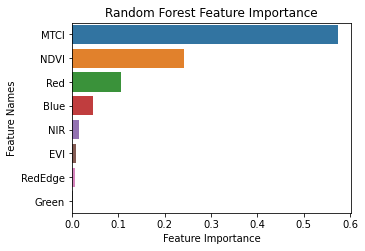

In [37]:

plot_feature_importance(model.feature_importances_,X_train.columns,'Random Forest ')


In [38]:
param=[x/10 for x in range(1,11)]
param=[1]

scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    for rs in range(10):
        # Create separate train/test splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        # Training best performing models
        model = GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)   
        R2.append(r2_score(y_test, y_pred))
    accuracy['R2'] = R2
#     print(accuracy)
    for k, s in accuracy.items():
        scores[pr]=(sum(s)/len(s))
scores
# Changing the number of n_estimator doesnt affect the resutls


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


{1: 0.7139824275506774}

,feature_names,feature_importance
6,MTCI,0.517352
5,NDVI,0.200786
7,EVI,0.076553
2,Red,0.074000
0,Blue,0.065108
4,NIR,0.026665
1,Green,0.022449
3,RedEdge,0.017087


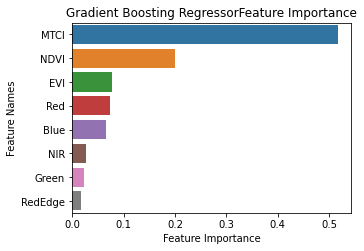

In [39]:
plot_feature_importance(model.feature_importances_,X_train.columns,'Gradient Boosting Regressor')


In [40]:
param=[x for x in range(8,15,2 ) ]
param=[1]
scores={}
for pr in tqdm(param):
    accuracy = {}
    R2 = []
    for rs in range(10):
        # Create separate train/test splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
        X_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        # Training best performing models
        model = CatBoostRegressor(depth=8)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)   
        R2.append(r2_score(y_test, y_pred))
    accuracy['R2'] = R2
    for k, s in accuracy.items():
        scores[pr]=(sum(s)/len(s))
scores

  0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Learning rate set to 0.024124
0:	learn: 100.7446504	total: 2.07ms	remaining: 2.07s
1:	learn: 99.4226747	total: 3.38ms	remaining: 1.69s
2:	learn: 98.1251605	total: 5.19ms	remaining: 1.72s
3:	learn: 96.8997002	total: 6.3ms	remaining: 1.57s
4:	learn: 95.7013712	total: 7.67ms	remaining: 1.52s
5:	learn: 94.5305492	total: 8.82ms	remaining: 1.46s
6:	learn: 93.5066251	total: 9.91ms	remaining: 1.41s
7:	learn: 92.3950261	total: 11.5ms	remaining: 1.43s
8:	learn: 91.3296282	total: 12.7ms	remaining: 1.4s
9:	learn: 90.2086980	total: 13.9ms	remaining: 1.37s
10:	learn: 89.2080041	total: 15ms	remaining: 1.34s
11:	learn: 88.0626022	total: 16.6ms	remaining: 1.36s
12:	learn: 87.0955304	total: 18ms	remaining: 1.37s
13:	learn: 86.0270899	total: 19.6ms	remaining: 1.38s
14:	learn: 84.9758449	total: 21.3ms	remaining: 1.4s
15:	learn: 83.8379701	total: 23ms	remaining: 1.41s
16:	learn: 82.9077959	total: 24.2ms	remaining: 1.4s
17:	learn: 81.7411432	total: 25.7ms	remaining: 1.4s
18:	learn: 80.7718548	total: 26.9ms	

216:	learn: 20.9007066	total: 331ms	remaining: 1.19s
217:	learn: 20.7701632	total: 333ms	remaining: 1.19s
218:	learn: 20.6437582	total: 335ms	remaining: 1.19s
219:	learn: 20.5787446	total: 337ms	remaining: 1.19s
220:	learn: 20.5024391	total: 339ms	remaining: 1.19s
221:	learn: 20.4156195	total: 340ms	remaining: 1.19s
222:	learn: 20.3214566	total: 342ms	remaining: 1.19s
223:	learn: 20.1911956	total: 344ms	remaining: 1.19s
224:	learn: 20.0478118	total: 346ms	remaining: 1.19s
225:	learn: 19.9469752	total: 348ms	remaining: 1.19s
226:	learn: 19.8329097	total: 350ms	remaining: 1.19s
227:	learn: 19.7092487	total: 352ms	remaining: 1.19s
228:	learn: 19.6386369	total: 354ms	remaining: 1.19s
229:	learn: 19.5244393	total: 357ms	remaining: 1.19s
230:	learn: 19.4786415	total: 358ms	remaining: 1.19s
231:	learn: 19.4076482	total: 359ms	remaining: 1.19s
232:	learn: 19.3067775	total: 361ms	remaining: 1.19s
233:	learn: 19.1922398	total: 363ms	remaining: 1.19s
234:	learn: 19.0816461	total: 365ms	remaining:

429:	learn: 9.1162265	total: 667ms	remaining: 885ms
430:	learn: 9.0956617	total: 669ms	remaining: 884ms
431:	learn: 9.0767593	total: 671ms	remaining: 882ms
432:	learn: 9.0299409	total: 672ms	remaining: 880ms
433:	learn: 9.0046494	total: 674ms	remaining: 879ms
434:	learn: 8.9859500	total: 675ms	remaining: 877ms
435:	learn: 8.9314468	total: 677ms	remaining: 875ms
436:	learn: 8.8874075	total: 678ms	remaining: 874ms
437:	learn: 8.8628681	total: 680ms	remaining: 873ms
438:	learn: 8.8387307	total: 682ms	remaining: 871ms
439:	learn: 8.7942724	total: 684ms	remaining: 870ms
440:	learn: 8.7783704	total: 685ms	remaining: 868ms
441:	learn: 8.7358300	total: 687ms	remaining: 867ms
442:	learn: 8.7122027	total: 688ms	remaining: 866ms
443:	learn: 8.6967702	total: 689ms	remaining: 863ms
444:	learn: 8.6736567	total: 690ms	remaining: 861ms
445:	learn: 8.6317928	total: 692ms	remaining: 859ms
446:	learn: 8.6104681	total: 692ms	remaining: 857ms
447:	learn: 8.5679865	total: 694ms	remaining: 855ms
448:	learn: 

663:	learn: 4.0763920	total: 1.01s	remaining: 510ms
664:	learn: 4.0629227	total: 1.01s	remaining: 509ms
665:	learn: 4.0451881	total: 1.01s	remaining: 507ms
666:	learn: 4.0318579	total: 1.01s	remaining: 506ms
667:	learn: 4.0155580	total: 1.01s	remaining: 505ms
668:	learn: 4.0023508	total: 1.02s	remaining: 504ms
669:	learn: 3.9892987	total: 1.02s	remaining: 502ms
670:	learn: 3.9731396	total: 1.02s	remaining: 501ms
671:	learn: 3.9602073	total: 1.02s	remaining: 499ms
672:	learn: 3.9474266	total: 1.02s	remaining: 498ms
673:	learn: 3.9314068	total: 1.03s	remaining: 497ms
674:	learn: 3.9128045	total: 1.03s	remaining: 496ms
675:	learn: 3.8976919	total: 1.03s	remaining: 494ms
676:	learn: 3.8822088	total: 1.03s	remaining: 493ms
677:	learn: 3.8700448	total: 1.03s	remaining: 492ms
678:	learn: 3.8552584	total: 1.04s	remaining: 491ms
679:	learn: 3.8432100	total: 1.04s	remaining: 490ms
680:	learn: 3.8285791	total: 1.04s	remaining: 488ms
681:	learn: 3.8166451	total: 1.04s	remaining: 487ms
682:	learn: 

883:	learn: 1.8413415	total: 1.35s	remaining: 177ms
884:	learn: 1.8297422	total: 1.35s	remaining: 176ms
885:	learn: 1.8177290	total: 1.35s	remaining: 174ms
886:	learn: 1.8131110	total: 1.35s	remaining: 173ms
887:	learn: 1.8085408	total: 1.36s	remaining: 171ms
888:	learn: 1.8022750	total: 1.36s	remaining: 170ms
889:	learn: 1.7910777	total: 1.36s	remaining: 168ms
890:	learn: 1.7795377	total: 1.36s	remaining: 167ms
891:	learn: 1.7750355	total: 1.36s	remaining: 165ms
892:	learn: 1.7641639	total: 1.37s	remaining: 164ms
893:	learn: 1.7597203	total: 1.37s	remaining: 162ms
894:	learn: 1.7543996	total: 1.37s	remaining: 161ms
895:	learn: 1.7499885	total: 1.37s	remaining: 159ms
896:	learn: 1.7447033	total: 1.38s	remaining: 158ms
897:	learn: 1.7403245	total: 1.38s	remaining: 156ms
898:	learn: 1.7350745	total: 1.38s	remaining: 155ms
899:	learn: 1.7307277	total: 1.38s	remaining: 153ms
900:	learn: 1.7255127	total: 1.38s	remaining: 152ms
901:	learn: 1.7211977	total: 1.38s	remaining: 150ms
902:	learn: 

44:	learn: 61.0728971	total: 82.3ms	remaining: 1.75s
45:	learn: 60.4924087	total: 85.1ms	remaining: 1.76s
46:	learn: 59.8944980	total: 89ms	remaining: 1.8s
47:	learn: 59.3316688	total: 92.6ms	remaining: 1.84s
48:	learn: 58.8293982	total: 95.9ms	remaining: 1.86s
49:	learn: 58.2228612	total: 97.5ms	remaining: 1.85s
50:	learn: 57.7247946	total: 98.6ms	remaining: 1.83s
51:	learn: 57.2453055	total: 99.6ms	remaining: 1.82s
52:	learn: 56.8044539	total: 101ms	remaining: 1.8s
53:	learn: 56.3261071	total: 102ms	remaining: 1.79s
54:	learn: 55.8735115	total: 104ms	remaining: 1.79s
55:	learn: 55.4525822	total: 107ms	remaining: 1.8s
56:	learn: 54.9445580	total: 109ms	remaining: 1.81s
57:	learn: 54.5678430	total: 111ms	remaining: 1.81s
58:	learn: 54.1364743	total: 113ms	remaining: 1.81s
59:	learn: 53.6211413	total: 115ms	remaining: 1.81s
60:	learn: 53.1775619	total: 117ms	remaining: 1.81s
61:	learn: 52.7464202	total: 120ms	remaining: 1.81s
62:	learn: 52.2845143	total: 121ms	remaining: 1.8s
63:	learn:

221:	learn: 21.2811015	total: 420ms	remaining: 1.47s
222:	learn: 21.1636419	total: 422ms	remaining: 1.47s
223:	learn: 21.0640932	total: 423ms	remaining: 1.47s
224:	learn: 21.0190821	total: 424ms	remaining: 1.46s
225:	learn: 20.8920860	total: 426ms	remaining: 1.46s
226:	learn: 20.8144614	total: 428ms	remaining: 1.46s
227:	learn: 20.7548204	total: 429ms	remaining: 1.45s
228:	learn: 20.6500801	total: 432ms	remaining: 1.45s
229:	learn: 20.5187520	total: 434ms	remaining: 1.45s
230:	learn: 20.4132212	total: 436ms	remaining: 1.45s
231:	learn: 20.3118565	total: 439ms	remaining: 1.45s
232:	learn: 20.2113776	total: 441ms	remaining: 1.45s
233:	learn: 20.1164379	total: 444ms	remaining: 1.45s
234:	learn: 19.9933643	total: 445ms	remaining: 1.45s
235:	learn: 19.9019634	total: 447ms	remaining: 1.45s
236:	learn: 19.8339274	total: 450ms	remaining: 1.45s
237:	learn: 19.7156556	total: 452ms	remaining: 1.45s
238:	learn: 19.6257000	total: 454ms	remaining: 1.45s
239:	learn: 19.6052941	total: 455ms	remaining:

418:	learn: 9.3590452	total: 760ms	remaining: 1.05s
419:	learn: 9.3090138	total: 762ms	remaining: 1.05s
420:	learn: 9.2598613	total: 764ms	remaining: 1.05s
421:	learn: 9.2115728	total: 766ms	remaining: 1.05s
422:	learn: 9.1641334	total: 767ms	remaining: 1.05s
423:	learn: 9.1175284	total: 769ms	remaining: 1.04s
424:	learn: 9.0657273	total: 771ms	remaining: 1.04s
425:	learn: 9.0346423	total: 773ms	remaining: 1.04s
426:	learn: 9.0039616	total: 775ms	remaining: 1.04s
427:	learn: 8.9756224	total: 777ms	remaining: 1.04s
428:	learn: 8.9448252	total: 779ms	remaining: 1.04s
429:	learn: 8.9005027	total: 781ms	remaining: 1.03s
430:	learn: 8.8701974	total: 782ms	remaining: 1.03s
431:	learn: 8.8413528	total: 784ms	remaining: 1.03s
432:	learn: 8.8116467	total: 786ms	remaining: 1.03s
433:	learn: 8.7838530	total: 788ms	remaining: 1.03s
434:	learn: 8.7354482	total: 790ms	remaining: 1.03s
435:	learn: 8.7081186	total: 792ms	remaining: 1.02s
436:	learn: 8.6791601	total: 794ms	remaining: 1.02s
437:	learn: 

606:	learn: 5.0359350	total: 1.1s	remaining: 710ms
607:	learn: 5.0253637	total: 1.1s	remaining: 709ms
608:	learn: 5.0127861	total: 1.1s	remaining: 707ms
609:	learn: 5.0023100	total: 1.1s	remaining: 705ms
610:	learn: 4.9756694	total: 1.1s	remaining: 703ms
611:	learn: 4.9653154	total: 1.11s	remaining: 701ms
612:	learn: 4.9457347	total: 1.11s	remaining: 700ms
613:	learn: 4.9174051	total: 1.11s	remaining: 698ms
614:	learn: 4.9072666	total: 1.11s	remaining: 696ms
615:	learn: 4.8843049	total: 1.11s	remaining: 694ms
616:	learn: 4.8613374	total: 1.11s	remaining: 693ms
617:	learn: 4.8338064	total: 1.12s	remaining: 691ms
618:	learn: 4.8114967	total: 1.12s	remaining: 689ms
619:	learn: 4.8015664	total: 1.12s	remaining: 687ms
620:	learn: 4.7771258	total: 1.12s	remaining: 685ms
621:	learn: 4.7504035	total: 1.12s	remaining: 683ms
622:	learn: 4.7240954	total: 1.12s	remaining: 681ms
623:	learn: 4.7100530	total: 1.13s	remaining: 679ms
624:	learn: 4.6887105	total: 1.13s	remaining: 677ms
625:	learn: 4.665

793:	learn: 2.5876161	total: 1.44s	remaining: 373ms
794:	learn: 2.5802573	total: 1.44s	remaining: 371ms
795:	learn: 2.5698990	total: 1.44s	remaining: 369ms
796:	learn: 2.5628732	total: 1.44s	remaining: 368ms
797:	learn: 2.5556566	total: 1.45s	remaining: 366ms
798:	learn: 2.5485381	total: 1.45s	remaining: 364ms
799:	learn: 2.5386081	total: 1.45s	remaining: 362ms
800:	learn: 2.5295499	total: 1.45s	remaining: 361ms
801:	learn: 2.5227002	total: 1.45s	remaining: 359ms
802:	learn: 2.5137283	total: 1.46s	remaining: 357ms
803:	learn: 2.5048630	total: 1.46s	remaining: 355ms
804:	learn: 2.4980544	total: 1.46s	remaining: 353ms
805:	learn: 2.4892733	total: 1.46s	remaining: 352ms
806:	learn: 2.4825267	total: 1.46s	remaining: 350ms
807:	learn: 2.4757047	total: 1.46s	remaining: 348ms
808:	learn: 2.4660655	total: 1.46s	remaining: 346ms
809:	learn: 2.4573744	total: 1.47s	remaining: 344ms
810:	learn: 2.4487865	total: 1.47s	remaining: 342ms
811:	learn: 2.4417263	total: 1.47s	remaining: 340ms
812:	learn: 

7:	learn: 93.1258400	total: 17.5ms	remaining: 2.17s
8:	learn: 92.1563762	total: 18.5ms	remaining: 2.03s
9:	learn: 91.0407919	total: 20.3ms	remaining: 2s
10:	learn: 89.9603447	total: 22ms	remaining: 1.98s
11:	learn: 88.8529727	total: 24ms	remaining: 1.97s
12:	learn: 87.8159249	total: 25.1ms	remaining: 1.91s
13:	learn: 86.7976672	total: 26.3ms	remaining: 1.85s
14:	learn: 85.7941356	total: 27.4ms	remaining: 1.8s
15:	learn: 84.7710921	total: 28.2ms	remaining: 1.74s
16:	learn: 83.7252360	total: 29.3ms	remaining: 1.7s
17:	learn: 82.8470772	total: 30.5ms	remaining: 1.66s
18:	learn: 81.8946394	total: 32.2ms	remaining: 1.66s
19:	learn: 80.9361410	total: 32.9ms	remaining: 1.61s
20:	learn: 79.8983023	total: 34.5ms	remaining: 1.61s
21:	learn: 79.0705123	total: 35.6ms	remaining: 1.58s
22:	learn: 77.9936511	total: 36.1ms	remaining: 1.53s
23:	learn: 77.2252253	total: 37.2ms	remaining: 1.51s
24:	learn: 76.3203823	total: 38.4ms	remaining: 1.5s
25:	learn: 75.5521318	total: 40.1ms	remaining: 1.5s
26:	lea

216:	learn: 22.0740380	total: 359ms	remaining: 1.3s
217:	learn: 22.0051060	total: 361ms	remaining: 1.3s
218:	learn: 21.9703942	total: 363ms	remaining: 1.29s
219:	learn: 21.8190069	total: 365ms	remaining: 1.29s
220:	learn: 21.7378878	total: 367ms	remaining: 1.29s
221:	learn: 21.6234025	total: 368ms	remaining: 1.29s
222:	learn: 21.5203593	total: 370ms	remaining: 1.29s
223:	learn: 21.4156530	total: 372ms	remaining: 1.29s
224:	learn: 21.3165405	total: 373ms	remaining: 1.29s
225:	learn: 21.2345598	total: 375ms	remaining: 1.28s
226:	learn: 21.1199462	total: 378ms	remaining: 1.29s
227:	learn: 21.0283785	total: 381ms	remaining: 1.29s
228:	learn: 20.9502591	total: 383ms	remaining: 1.29s
229:	learn: 20.8115742	total: 385ms	remaining: 1.29s
230:	learn: 20.7406108	total: 386ms	remaining: 1.29s
231:	learn: 20.6810119	total: 388ms	remaining: 1.28s
232:	learn: 20.6134598	total: 390ms	remaining: 1.28s
233:	learn: 20.5380432	total: 391ms	remaining: 1.28s
234:	learn: 20.3936460	total: 394ms	remaining: 1

373:	learn: 12.1450352	total: 697ms	remaining: 1.17s
374:	learn: 12.1069001	total: 699ms	remaining: 1.17s
375:	learn: 12.0699827	total: 701ms	remaining: 1.16s
376:	learn: 12.0312113	total: 704ms	remaining: 1.16s
377:	learn: 11.9960991	total: 706ms	remaining: 1.16s
378:	learn: 11.9160650	total: 708ms	remaining: 1.16s
379:	learn: 11.8816443	total: 711ms	remaining: 1.16s
380:	learn: 11.8488057	total: 713ms	remaining: 1.16s
381:	learn: 11.7893402	total: 715ms	remaining: 1.16s
382:	learn: 11.7553393	total: 718ms	remaining: 1.16s
383:	learn: 11.7114799	total: 720ms	remaining: 1.15s
384:	learn: 11.6791409	total: 722ms	remaining: 1.15s
385:	learn: 11.6204001	total: 724ms	remaining: 1.15s
386:	learn: 11.5873729	total: 726ms	remaining: 1.15s
387:	learn: 11.5305496	total: 728ms	remaining: 1.15s
388:	learn: 11.4978795	total: 729ms	remaining: 1.15s
389:	learn: 11.4552653	total: 731ms	remaining: 1.14s
390:	learn: 11.4227870	total: 732ms	remaining: 1.14s
391:	learn: 11.3906127	total: 734ms	remaining:

559:	learn: 6.6661017	total: 1.04s	remaining: 815ms
560:	learn: 6.6515943	total: 1.04s	remaining: 812ms
561:	learn: 6.6311504	total: 1.04s	remaining: 811ms
562:	learn: 6.6168543	total: 1.04s	remaining: 808ms
563:	learn: 6.5966218	total: 1.04s	remaining: 807ms
564:	learn: 6.5766446	total: 1.05s	remaining: 805ms
565:	learn: 6.5600853	total: 1.05s	remaining: 803ms
566:	learn: 6.5403177	total: 1.05s	remaining: 801ms
567:	learn: 6.5263544	total: 1.05s	remaining: 798ms
568:	learn: 6.5067916	total: 1.05s	remaining: 797ms
569:	learn: 6.4695217	total: 1.05s	remaining: 795ms
570:	learn: 6.4501856	total: 1.05s	remaining: 793ms
571:	learn: 6.4310927	total: 1.06s	remaining: 792ms
572:	learn: 6.3943047	total: 1.06s	remaining: 790ms
573:	learn: 6.3845375	total: 1.06s	remaining: 789ms
574:	learn: 6.3482543	total: 1.06s	remaining: 787ms
575:	learn: 6.3396681	total: 1.07s	remaining: 785ms
576:	learn: 6.3209341	total: 1.07s	remaining: 783ms
577:	learn: 6.2888292	total: 1.07s	remaining: 781ms
578:	learn: 

762:	learn: 3.2967007	total: 1.38s	remaining: 428ms
763:	learn: 3.2840984	total: 1.38s	remaining: 427ms
764:	learn: 3.2727818	total: 1.38s	remaining: 425ms
765:	learn: 3.2597120	total: 1.39s	remaining: 423ms
766:	learn: 3.2493312	total: 1.39s	remaining: 422ms
767:	learn: 3.2382367	total: 1.39s	remaining: 420ms
768:	learn: 3.2279475	total: 1.39s	remaining: 418ms
769:	learn: 3.2151638	total: 1.39s	remaining: 416ms
770:	learn: 3.2042866	total: 1.4s	remaining: 415ms
771:	learn: 3.1940864	total: 1.4s	remaining: 413ms
772:	learn: 3.1815837	total: 1.4s	remaining: 411ms
773:	learn: 3.1710622	total: 1.4s	remaining: 409ms
774:	learn: 3.1587288	total: 1.4s	remaining: 407ms
775:	learn: 3.1483276	total: 1.4s	remaining: 405ms
776:	learn: 3.1377662	total: 1.41s	remaining: 403ms
777:	learn: 3.1244588	total: 1.41s	remaining: 402ms
778:	learn: 3.1113290	total: 1.41s	remaining: 400ms
779:	learn: 3.0983739	total: 1.41s	remaining: 398ms
780:	learn: 3.0855907	total: 1.41s	remaining: 396ms
781:	learn: 3.0721

934:	learn: 1.8932863	total: 1.72s	remaining: 119ms
935:	learn: 1.8901392	total: 1.72s	remaining: 118ms
936:	learn: 1.8847871	total: 1.72s	remaining: 116ms
937:	learn: 1.8816706	total: 1.72s	remaining: 114ms
938:	learn: 1.8763631	total: 1.73s	remaining: 112ms
939:	learn: 1.8732768	total: 1.73s	remaining: 110ms
940:	learn: 1.8695341	total: 1.73s	remaining: 108ms
941:	learn: 1.8665108	total: 1.73s	remaining: 106ms
942:	learn: 1.8635271	total: 1.73s	remaining: 105ms
943:	learn: 1.8582532	total: 1.73s	remaining: 103ms
944:	learn: 1.8552983	total: 1.73s	remaining: 101ms
945:	learn: 1.8476736	total: 1.73s	remaining: 99ms
946:	learn: 1.8447454	total: 1.74s	remaining: 97.2ms
947:	learn: 1.8395473	total: 1.74s	remaining: 95.3ms
948:	learn: 1.8366473	total: 1.74s	remaining: 93.5ms
949:	learn: 1.8291283	total: 1.74s	remaining: 91.6ms
950:	learn: 1.8225224	total: 1.74s	remaining: 89.8ms
951:	learn: 1.8196678	total: 1.74s	remaining: 87.9ms
952:	learn: 1.8145305	total: 1.75s	remaining: 86.1ms
953:	l

114:	learn: 39.1118082	total: 175ms	remaining: 1.34s
115:	learn: 38.8125539	total: 176ms	remaining: 1.34s
116:	learn: 38.5682719	total: 178ms	remaining: 1.34s
117:	learn: 38.3678122	total: 179ms	remaining: 1.34s
118:	learn: 38.1341432	total: 180ms	remaining: 1.34s
119:	learn: 37.9688167	total: 182ms	remaining: 1.33s
120:	learn: 37.7815896	total: 183ms	remaining: 1.33s
121:	learn: 37.5794267	total: 184ms	remaining: 1.32s
122:	learn: 37.3733885	total: 185ms	remaining: 1.32s
123:	learn: 37.1482667	total: 186ms	remaining: 1.31s
124:	learn: 36.9784921	total: 188ms	remaining: 1.31s
125:	learn: 36.7839996	total: 190ms	remaining: 1.32s
126:	learn: 36.5795777	total: 191ms	remaining: 1.31s
127:	learn: 36.3481635	total: 193ms	remaining: 1.31s
128:	learn: 36.1336237	total: 195ms	remaining: 1.31s
129:	learn: 35.8804961	total: 196ms	remaining: 1.31s
130:	learn: 35.7196641	total: 198ms	remaining: 1.31s
131:	learn: 35.5032710	total: 199ms	remaining: 1.31s
132:	learn: 35.3697886	total: 201ms	remaining:

283:	learn: 16.3006754	total: 512ms	remaining: 1.29s
284:	learn: 16.1963587	total: 514ms	remaining: 1.29s
285:	learn: 16.1324231	total: 516ms	remaining: 1.29s
286:	learn: 16.0349988	total: 517ms	remaining: 1.28s
287:	learn: 15.9697317	total: 519ms	remaining: 1.28s
288:	learn: 15.8798041	total: 520ms	remaining: 1.28s
289:	learn: 15.7933931	total: 522ms	remaining: 1.28s
290:	learn: 15.7308081	total: 524ms	remaining: 1.28s
291:	learn: 15.6345730	total: 526ms	remaining: 1.28s
292:	learn: 15.5945654	total: 528ms	remaining: 1.27s
293:	learn: 15.5011131	total: 530ms	remaining: 1.27s
294:	learn: 15.4028724	total: 532ms	remaining: 1.27s
295:	learn: 15.3380425	total: 534ms	remaining: 1.27s
296:	learn: 15.2484698	total: 535ms	remaining: 1.27s
297:	learn: 15.1552941	total: 536ms	remaining: 1.26s
298:	learn: 15.0908118	total: 538ms	remaining: 1.26s
299:	learn: 15.0277626	total: 539ms	remaining: 1.26s
300:	learn: 14.9557028	total: 541ms	remaining: 1.25s
301:	learn: 14.9063542	total: 542ms	remaining:

458:	learn: 7.7377205	total: 852ms	remaining: 1s
459:	learn: 7.7231892	total: 854ms	remaining: 1s
460:	learn: 7.6935475	total: 856ms	remaining: 1s
461:	learn: 7.6700624	total: 857ms	remaining: 998ms
462:	learn: 7.6415255	total: 859ms	remaining: 997ms
463:	learn: 7.6283119	total: 862ms	remaining: 995ms
464:	learn: 7.5771077	total: 864ms	remaining: 994ms
465:	learn: 7.5527889	total: 865ms	remaining: 991ms
466:	learn: 7.5313021	total: 866ms	remaining: 989ms
467:	learn: 7.5033507	total: 869ms	remaining: 988ms
468:	learn: 7.4757891	total: 871ms	remaining: 987ms
469:	learn: 7.4627428	total: 874ms	remaining: 985ms
470:	learn: 7.4402055	total: 875ms	remaining: 983ms
471:	learn: 7.4129717	total: 877ms	remaining: 982ms
472:	learn: 7.3903702	total: 880ms	remaining: 980ms
473:	learn: 7.3680331	total: 881ms	remaining: 978ms
474:	learn: 7.3446455	total: 883ms	remaining: 976ms
475:	learn: 7.3216867	total: 885ms	remaining: 974ms
476:	learn: 7.2991489	total: 887ms	remaining: 973ms
477:	learn: 7.2836077

620:	learn: 4.8599867	total: 1.18s	remaining: 722ms
621:	learn: 4.8394290	total: 1.19s	remaining: 721ms
622:	learn: 4.8203569	total: 1.19s	remaining: 719ms
623:	learn: 4.8125810	total: 1.19s	remaining: 717ms
624:	learn: 4.7924973	total: 1.19s	remaining: 715ms
625:	learn: 4.7742608	total: 1.19s	remaining: 713ms
626:	learn: 4.7562288	total: 1.2s	remaining: 711ms
627:	learn: 4.7363552	total: 1.2s	remaining: 710ms
628:	learn: 4.7192367	total: 1.2s	remaining: 707ms
629:	learn: 4.7131997	total: 1.2s	remaining: 706ms
630:	learn: 4.6937275	total: 1.2s	remaining: 704ms
631:	learn: 4.6843294	total: 1.2s	remaining: 701ms
632:	learn: 4.6668387	total: 1.21s	remaining: 699ms
633:	learn: 4.6608945	total: 1.21s	remaining: 698ms
634:	learn: 4.6550153	total: 1.21s	remaining: 696ms
635:	learn: 4.6357070	total: 1.21s	remaining: 694ms
636:	learn: 4.6167492	total: 1.21s	remaining: 692ms
637:	learn: 4.6074400	total: 1.22s	remaining: 690ms
638:	learn: 4.5896589	total: 1.22s	remaining: 688ms
639:	learn: 4.5847

815:	learn: 2.5385929	total: 1.52s	remaining: 343ms
816:	learn: 2.5338371	total: 1.52s	remaining: 342ms
817:	learn: 2.5261912	total: 1.53s	remaining: 340ms
818:	learn: 2.5179009	total: 1.53s	remaining: 338ms
819:	learn: 2.5097038	total: 1.53s	remaining: 336ms
820:	learn: 2.4982336	total: 1.53s	remaining: 334ms
821:	learn: 2.4901476	total: 1.53s	remaining: 332ms
822:	learn: 2.4821528	total: 1.54s	remaining: 330ms
823:	learn: 2.4764918	total: 1.54s	remaining: 329ms
824:	learn: 2.4717083	total: 1.54s	remaining: 327ms
825:	learn: 2.4641343	total: 1.54s	remaining: 325ms
826:	learn: 2.4566518	total: 1.54s	remaining: 323ms
827:	learn: 2.4487284	total: 1.54s	remaining: 321ms
828:	learn: 2.4408942	total: 1.55s	remaining: 319ms
829:	learn: 2.4334535	total: 1.55s	remaining: 317ms
830:	learn: 2.4256834	total: 1.55s	remaining: 316ms
831:	learn: 2.4135474	total: 1.55s	remaining: 314ms
832:	learn: 2.4040140	total: 1.55s	remaining: 312ms
833:	learn: 2.3946027	total: 1.56s	remaining: 310ms
834:	learn: 

993:	learn: 1.5057928	total: 1.87s	remaining: 11.3ms
994:	learn: 1.5027038	total: 1.87s	remaining: 9.4ms
995:	learn: 1.5001251	total: 1.87s	remaining: 7.52ms
996:	learn: 1.4925898	total: 1.88s	remaining: 5.64ms
997:	learn: 1.4853868	total: 1.88s	remaining: 3.76ms
998:	learn: 1.4806788	total: 1.88s	remaining: 1.88ms
999:	learn: 1.4764073	total: 1.88s	remaining: 0us
Learning rate set to 0.024124
0:	learn: 101.1064425	total: 2.95ms	remaining: 2.95s
1:	learn: 99.8787248	total: 4.88ms	remaining: 2.43s
2:	learn: 98.6848703	total: 7.58ms	remaining: 2.52s
3:	learn: 97.4207059	total: 10ms	remaining: 2.49s
4:	learn: 96.1688737	total: 12ms	remaining: 2.39s
5:	learn: 94.9280625	total: 13.5ms	remaining: 2.24s
6:	learn: 93.9290535	total: 14.7ms	remaining: 2.09s
7:	learn: 92.7639006	total: 15.9ms	remaining: 1.97s
8:	learn: 91.7919376	total: 17ms	remaining: 1.88s
9:	learn: 90.6427630	total: 18.1ms	remaining: 1.79s
10:	learn: 89.5820919	total: 19.1ms	remaining: 1.72s
11:	learn: 88.3549614	total: 20.5ms

159:	learn: 28.6392894	total: 256ms	remaining: 1.35s
160:	learn: 28.4860687	total: 258ms	remaining: 1.35s
161:	learn: 28.3735922	total: 260ms	remaining: 1.34s
162:	learn: 28.2189469	total: 261ms	remaining: 1.34s
163:	learn: 28.0644062	total: 262ms	remaining: 1.34s
164:	learn: 27.9283241	total: 264ms	remaining: 1.34s
165:	learn: 27.8179995	total: 266ms	remaining: 1.34s
166:	learn: 27.6740741	total: 268ms	remaining: 1.34s
167:	learn: 27.5537606	total: 270ms	remaining: 1.34s
168:	learn: 27.3861011	total: 272ms	remaining: 1.34s
169:	learn: 27.2160692	total: 274ms	remaining: 1.34s
170:	learn: 27.0803785	total: 276ms	remaining: 1.34s
171:	learn: 26.9609808	total: 278ms	remaining: 1.34s
172:	learn: 26.8300892	total: 280ms	remaining: 1.34s
173:	learn: 26.6980714	total: 282ms	remaining: 1.34s
174:	learn: 26.5202645	total: 284ms	remaining: 1.34s
175:	learn: 26.4227938	total: 285ms	remaining: 1.34s
176:	learn: 26.3069090	total: 287ms	remaining: 1.33s
177:	learn: 26.1370626	total: 288ms	remaining:

376:	learn: 11.4806479	total: 596ms	remaining: 985ms
377:	learn: 11.4629838	total: 598ms	remaining: 984ms
378:	learn: 11.4339642	total: 600ms	remaining: 983ms
379:	learn: 11.3719607	total: 602ms	remaining: 982ms
380:	learn: 11.3453584	total: 603ms	remaining: 980ms
381:	learn: 11.2894928	total: 606ms	remaining: 980ms
382:	learn: 11.2288161	total: 607ms	remaining: 978ms
383:	learn: 11.2116572	total: 608ms	remaining: 976ms
384:	learn: 11.1853567	total: 610ms	remaining: 974ms
385:	learn: 11.1630162	total: 612ms	remaining: 973ms
386:	learn: 11.1036524	total: 613ms	remaining: 972ms
387:	learn: 11.0801302	total: 615ms	remaining: 971ms
388:	learn: 11.0220540	total: 617ms	remaining: 970ms
389:	learn: 10.9641136	total: 619ms	remaining: 969ms
390:	learn: 10.9306174	total: 621ms	remaining: 968ms
391:	learn: 10.8959688	total: 624ms	remaining: 967ms
392:	learn: 10.8798558	total: 625ms	remaining: 965ms
393:	learn: 10.8639513	total: 626ms	remaining: 963ms
394:	learn: 10.8068875	total: 628ms	remaining:

578:	learn: 6.2442244	total: 939ms	remaining: 683ms
579:	learn: 6.2032761	total: 941ms	remaining: 681ms
580:	learn: 6.1865120	total: 942ms	remaining: 679ms
581:	learn: 6.1690968	total: 943ms	remaining: 677ms
582:	learn: 6.1605258	total: 945ms	remaining: 676ms
583:	learn: 6.1262159	total: 946ms	remaining: 674ms
584:	learn: 6.0861864	total: 947ms	remaining: 672ms
585:	learn: 6.0710317	total: 948ms	remaining: 670ms
586:	learn: 6.0313376	total: 950ms	remaining: 668ms
587:	learn: 6.0097905	total: 951ms	remaining: 666ms
588:	learn: 5.9708733	total: 953ms	remaining: 665ms
589:	learn: 5.9326441	total: 954ms	remaining: 663ms
590:	learn: 5.9177748	total: 955ms	remaining: 661ms
591:	learn: 5.9012151	total: 957ms	remaining: 659ms
592:	learn: 5.8804183	total: 957ms	remaining: 657ms
593:	learn: 5.8482230	total: 959ms	remaining: 655ms
594:	learn: 5.8159323	total: 960ms	remaining: 654ms
595:	learn: 5.7842766	total: 962ms	remaining: 652ms
596:	learn: 5.7641857	total: 963ms	remaining: 650ms
597:	learn: 

784:	learn: 3.2419275	total: 1.28s	remaining: 350ms
785:	learn: 3.2273468	total: 1.28s	remaining: 348ms
786:	learn: 3.2169167	total: 1.28s	remaining: 347ms
787:	learn: 3.2104411	total: 1.28s	remaining: 345ms
788:	learn: 3.1998215	total: 1.28s	remaining: 344ms
789:	learn: 3.1934462	total: 1.29s	remaining: 342ms
790:	learn: 3.1807493	total: 1.29s	remaining: 341ms
791:	learn: 3.1639457	total: 1.29s	remaining: 339ms
792:	learn: 3.1498270	total: 1.29s	remaining: 337ms
793:	learn: 3.1397909	total: 1.29s	remaining: 336ms
794:	learn: 3.1261896	total: 1.29s	remaining: 334ms
795:	learn: 3.1200099	total: 1.3s	remaining: 332ms
796:	learn: 3.1139018	total: 1.3s	remaining: 331ms
797:	learn: 3.1015751	total: 1.3s	remaining: 329ms
798:	learn: 3.0869102	total: 1.3s	remaining: 327ms
799:	learn: 3.0706395	total: 1.3s	remaining: 326ms
800:	learn: 3.0646260	total: 1.3s	remaining: 324ms
801:	learn: 3.0549858	total: 1.3s	remaining: 322ms
802:	learn: 3.0450314	total: 1.31s	remaining: 321ms
803:	learn: 3.03301

960:	learn: 1.7846721	total: 1.62s	remaining: 65.8ms
961:	learn: 1.7809426	total: 1.62s	remaining: 64.1ms
962:	learn: 1.7765133	total: 1.62s	remaining: 62.4ms
963:	learn: 1.7710554	total: 1.63s	remaining: 60.7ms
964:	learn: 1.7673734	total: 1.63s	remaining: 59.1ms
965:	learn: 1.7629923	total: 1.63s	remaining: 57.4ms
966:	learn: 1.7593471	total: 1.63s	remaining: 55.7ms
967:	learn: 1.7539651	total: 1.63s	remaining: 54ms
968:	learn: 1.7503763	total: 1.64s	remaining: 52.3ms
969:	learn: 1.7460326	total: 1.64s	remaining: 50.6ms
970:	learn: 1.7365630	total: 1.64s	remaining: 48.9ms
971:	learn: 1.7312867	total: 1.64s	remaining: 47.2ms
972:	learn: 1.7261199	total: 1.64s	remaining: 45.5ms
973:	learn: 1.7218856	total: 1.64s	remaining: 43.8ms
974:	learn: 1.7166596	total: 1.64s	remaining: 42.2ms
975:	learn: 1.7140621	total: 1.65s	remaining: 40.5ms
976:	learn: 1.7098916	total: 1.65s	remaining: 38.8ms
977:	learn: 1.7046878	total: 1.65s	remaining: 37.1ms
978:	learn: 1.6999959	total: 1.65s	remaining: 35

222:	learn: 21.3065606	total: 369ms	remaining: 1.28s
223:	learn: 21.1997340	total: 371ms	remaining: 1.28s
224:	learn: 21.0845049	total: 372ms	remaining: 1.28s
225:	learn: 21.0015044	total: 373ms	remaining: 1.28s
226:	learn: 20.8882672	total: 375ms	remaining: 1.28s
227:	learn: 20.7628171	total: 376ms	remaining: 1.27s
228:	learn: 20.6388133	total: 377ms	remaining: 1.27s
229:	learn: 20.5492181	total: 379ms	remaining: 1.27s
230:	learn: 20.4267719	total: 380ms	remaining: 1.26s
231:	learn: 20.3359519	total: 381ms	remaining: 1.26s
232:	learn: 20.2132098	total: 383ms	remaining: 1.26s
233:	learn: 20.1208354	total: 384ms	remaining: 1.26s
234:	learn: 20.0087988	total: 385ms	remaining: 1.25s
235:	learn: 19.9193025	total: 387ms	remaining: 1.25s
236:	learn: 19.8288783	total: 388ms	remaining: 1.25s
237:	learn: 19.7477345	total: 389ms	remaining: 1.25s
238:	learn: 19.6584327	total: 391ms	remaining: 1.24s
239:	learn: 19.5535321	total: 392ms	remaining: 1.24s
240:	learn: 19.4719900	total: 393ms	remaining:

400:	learn: 9.9284103	total: 709ms	remaining: 1.06s
401:	learn: 9.9004428	total: 711ms	remaining: 1.06s
402:	learn: 9.8621178	total: 713ms	remaining: 1.06s
403:	learn: 9.8243666	total: 714ms	remaining: 1.05s
404:	learn: 9.7815917	total: 716ms	remaining: 1.05s
405:	learn: 9.7542058	total: 717ms	remaining: 1.05s
406:	learn: 9.7194305	total: 718ms	remaining: 1.05s
407:	learn: 9.6854734	total: 720ms	remaining: 1.04s
408:	learn: 9.6519592	total: 721ms	remaining: 1.04s
409:	learn: 9.6099949	total: 722ms	remaining: 1.04s
410:	learn: 9.5684599	total: 724ms	remaining: 1.04s
411:	learn: 9.5351333	total: 725ms	remaining: 1.03s
412:	learn: 9.5022399	total: 727ms	remaining: 1.03s
413:	learn: 9.4701365	total: 728ms	remaining: 1.03s
414:	learn: 9.4432714	total: 729ms	remaining: 1.03s
415:	learn: 9.4066027	total: 730ms	remaining: 1.02s
416:	learn: 9.3746550	total: 732ms	remaining: 1.02s
417:	learn: 9.3431230	total: 733ms	remaining: 1.02s
418:	learn: 9.3072661	total: 735ms	remaining: 1.02s
419:	learn: 

609:	learn: 4.6668325	total: 1.05s	remaining: 673ms
610:	learn: 4.6508780	total: 1.05s	remaining: 672ms
611:	learn: 4.6396444	total: 1.06s	remaining: 671ms
612:	learn: 4.6244963	total: 1.06s	remaining: 669ms
613:	learn: 4.6086721	total: 1.06s	remaining: 668ms
614:	learn: 4.5922652	total: 1.06s	remaining: 666ms
615:	learn: 4.5765822	total: 1.07s	remaining: 665ms
616:	learn: 4.5610506	total: 1.07s	remaining: 663ms
617:	learn: 4.5500574	total: 1.07s	remaining: 661ms
618:	learn: 4.5338919	total: 1.07s	remaining: 660ms
619:	learn: 4.5260438	total: 1.07s	remaining: 658ms
620:	learn: 4.5152509	total: 1.07s	remaining: 656ms
621:	learn: 4.4844027	total: 1.08s	remaining: 655ms
622:	learn: 4.4679201	total: 1.08s	remaining: 653ms
623:	learn: 4.4516471	total: 1.08s	remaining: 651ms
624:	learn: 4.4438977	total: 1.08s	remaining: 649ms
625:	learn: 4.4333999	total: 1.08s	remaining: 648ms
626:	learn: 4.4034352	total: 1.09s	remaining: 646ms
627:	learn: 4.3887617	total: 1.09s	remaining: 645ms
628:	learn: 

815:	learn: 2.3424842	total: 1.39s	remaining: 314ms
816:	learn: 2.3366880	total: 1.39s	remaining: 312ms
817:	learn: 2.3326654	total: 1.39s	remaining: 310ms
818:	learn: 2.3245244	total: 1.39s	remaining: 308ms
819:	learn: 2.3164821	total: 1.4s	remaining: 306ms
820:	learn: 2.3107899	total: 1.4s	remaining: 305ms
821:	learn: 2.3028408	total: 1.4s	remaining: 303ms
822:	learn: 2.2988777	total: 1.4s	remaining: 301ms
823:	learn: 2.2910096	total: 1.4s	remaining: 299ms
824:	learn: 2.2870956	total: 1.4s	remaining: 297ms
825:	learn: 2.2793077	total: 1.4s	remaining: 295ms
826:	learn: 2.2681705	total: 1.4s	remaining: 294ms
827:	learn: 2.2605502	total: 1.41s	remaining: 292ms
828:	learn: 2.2566532	total: 1.41s	remaining: 290ms
829:	learn: 2.2506544	total: 1.41s	remaining: 288ms
830:	learn: 2.2451272	total: 1.41s	remaining: 286ms
831:	learn: 2.2391877	total: 1.41s	remaining: 285ms
832:	learn: 2.2353658	total: 1.41s	remaining: 283ms
833:	learn: 2.2268894	total: 1.41s	remaining: 281ms
834:	learn: 2.218513

0:	learn: 101.4250202	total: 2.19ms	remaining: 2.18s
1:	learn: 100.0913753	total: 3.85ms	remaining: 1.92s
2:	learn: 98.6695396	total: 5.73ms	remaining: 1.9s
3:	learn: 97.4795190	total: 7.52ms	remaining: 1.87s
4:	learn: 96.2244362	total: 9.71ms	remaining: 1.93s
5:	learn: 95.1023604	total: 11.6ms	remaining: 1.91s
6:	learn: 93.9208521	total: 13.3ms	remaining: 1.89s
7:	learn: 92.5982334	total: 15.1ms	remaining: 1.87s
8:	learn: 91.4385548	total: 16.3ms	remaining: 1.8s
9:	learn: 90.3874600	total: 17.7ms	remaining: 1.75s
10:	learn: 89.3899733	total: 19.1ms	remaining: 1.72s
11:	learn: 88.3303023	total: 21.1ms	remaining: 1.74s
12:	learn: 87.3366883	total: 23.2ms	remaining: 1.76s
13:	learn: 86.3503132	total: 25.2ms	remaining: 1.78s
14:	learn: 85.4473743	total: 26.7ms	remaining: 1.75s
15:	learn: 84.3816943	total: 28ms	remaining: 1.72s
16:	learn: 83.3234020	total: 29.4ms	remaining: 1.7s
17:	learn: 82.4824848	total: 30.9ms	remaining: 1.69s
18:	learn: 81.5607760	total: 32.4ms	remaining: 1.67s
19:	le

206:	learn: 21.6834115	total: 336ms	remaining: 1.29s
207:	learn: 21.6009008	total: 338ms	remaining: 1.29s
208:	learn: 21.5387096	total: 340ms	remaining: 1.29s
209:	learn: 21.4598595	total: 343ms	remaining: 1.29s
210:	learn: 21.3051300	total: 345ms	remaining: 1.29s
211:	learn: 21.2231665	total: 347ms	remaining: 1.29s
212:	learn: 21.1167823	total: 350ms	remaining: 1.29s
213:	learn: 21.0153255	total: 352ms	remaining: 1.29s
214:	learn: 20.9111317	total: 357ms	remaining: 1.3s
215:	learn: 20.8087511	total: 360ms	remaining: 1.31s
216:	learn: 20.7088067	total: 363ms	remaining: 1.31s
217:	learn: 20.5669294	total: 365ms	remaining: 1.31s
218:	learn: 20.4929941	total: 367ms	remaining: 1.31s
219:	learn: 20.3861722	total: 369ms	remaining: 1.31s
220:	learn: 20.2697052	total: 370ms	remaining: 1.3s
221:	learn: 20.1746324	total: 372ms	remaining: 1.3s
222:	learn: 20.0744493	total: 374ms	remaining: 1.3s
223:	learn: 19.9620097	total: 376ms	remaining: 1.3s
224:	learn: 19.8695586	total: 378ms	remaining: 1.3s

382:	learn: 11.9108842	total: 677ms	remaining: 1.09s
383:	learn: 11.8594019	total: 678ms	remaining: 1.09s
384:	learn: 11.8348810	total: 680ms	remaining: 1.09s
385:	learn: 11.8108855	total: 682ms	remaining: 1.08s
386:	learn: 11.7889165	total: 683ms	remaining: 1.08s
387:	learn: 11.7566324	total: 685ms	remaining: 1.08s
388:	learn: 11.7348449	total: 687ms	remaining: 1.08s
389:	learn: 11.7029345	total: 688ms	remaining: 1.08s
390:	learn: 11.6813182	total: 689ms	remaining: 1.07s
391:	learn: 11.6065922	total: 691ms	remaining: 1.07s
392:	learn: 11.5752007	total: 692ms	remaining: 1.07s
393:	learn: 11.5442267	total: 694ms	remaining: 1.07s
394:	learn: 11.5185712	total: 696ms	remaining: 1.06s
395:	learn: 11.4879270	total: 697ms	remaining: 1.06s
396:	learn: 11.4646471	total: 699ms	remaining: 1.06s
397:	learn: 11.3982600	total: 701ms	remaining: 1.06s
398:	learn: 11.3772295	total: 703ms	remaining: 1.06s
399:	learn: 11.3544117	total: 705ms	remaining: 1.06s
400:	learn: 11.3337749	total: 707ms	remaining:

570:	learn: 6.8951478	total: 1.02s	remaining: 765ms
571:	learn: 6.8814870	total: 1.02s	remaining: 763ms
572:	learn: 6.8643975	total: 1.02s	remaining: 762ms
573:	learn: 6.8506062	total: 1.02s	remaining: 760ms
574:	learn: 6.8393593	total: 1.03s	remaining: 758ms
575:	learn: 6.8257259	total: 1.03s	remaining: 757ms
576:	learn: 6.8146056	total: 1.03s	remaining: 755ms
577:	learn: 6.8013234	total: 1.03s	remaining: 753ms
578:	learn: 6.7830762	total: 1.03s	remaining: 751ms
579:	learn: 6.7696846	total: 1.03s	remaining: 749ms
580:	learn: 6.7516063	total: 1.03s	remaining: 747ms
581:	learn: 6.7407519	total: 1.04s	remaining: 745ms
582:	learn: 6.7276749	total: 1.04s	remaining: 744ms
583:	learn: 6.7145214	total: 1.04s	remaining: 742ms
584:	learn: 6.6979524	total: 1.04s	remaining: 740ms
585:	learn: 6.6791295	total: 1.04s	remaining: 738ms
586:	learn: 6.6660476	total: 1.05s	remaining: 737ms
587:	learn: 6.6531092	total: 1.05s	remaining: 735ms
588:	learn: 6.6344280	total: 1.05s	remaining: 733ms
589:	learn: 

762:	learn: 3.8866428	total: 1.36s	remaining: 422ms
763:	learn: 3.8782288	total: 1.36s	remaining: 421ms
764:	learn: 3.8553893	total: 1.36s	remaining: 419ms
765:	learn: 3.8482135	total: 1.37s	remaining: 417ms
766:	learn: 3.8411213	total: 1.37s	remaining: 416ms
767:	learn: 3.8341118	total: 1.37s	remaining: 414ms
768:	learn: 3.8271840	total: 1.37s	remaining: 413ms
769:	learn: 3.8051084	total: 1.38s	remaining: 411ms
770:	learn: 3.7982360	total: 1.38s	remaining: 409ms
771:	learn: 3.7768605	total: 1.38s	remaining: 408ms
772:	learn: 3.7552688	total: 1.38s	remaining: 406ms
773:	learn: 3.7358050	total: 1.38s	remaining: 404ms
774:	learn: 3.7277915	total: 1.39s	remaining: 402ms
775:	learn: 3.7198658	total: 1.39s	remaining: 400ms
776:	learn: 3.7016685	total: 1.39s	remaining: 399ms
777:	learn: 3.6808551	total: 1.39s	remaining: 397ms
778:	learn: 3.6596578	total: 1.39s	remaining: 395ms
779:	learn: 3.6528646	total: 1.4s	remaining: 394ms
780:	learn: 3.6461501	total: 1.4s	remaining: 392ms
781:	learn: 3.

971:	learn: 1.8037571	total: 1.87s	remaining: 53.8ms
972:	learn: 1.7988115	total: 1.87s	remaining: 51.9ms
973:	learn: 1.7931102	total: 1.87s	remaining: 49.9ms
974:	learn: 1.7851840	total: 1.87s	remaining: 48ms
975:	learn: 1.7795496	total: 1.87s	remaining: 46.1ms
976:	learn: 1.7739750	total: 1.88s	remaining: 44.2ms
977:	learn: 1.7684596	total: 1.88s	remaining: 42.3ms
978:	learn: 1.7636110	total: 1.88s	remaining: 40.3ms
979:	learn: 1.7581510	total: 1.88s	remaining: 38.4ms
980:	learn: 1.7533582	total: 1.88s	remaining: 36.5ms
981:	learn: 1.7479531	total: 1.88s	remaining: 34.5ms
982:	learn: 1.7426055	total: 1.89s	remaining: 32.6ms
983:	learn: 1.7347816	total: 1.89s	remaining: 30.7ms
984:	learn: 1.7294962	total: 1.89s	remaining: 28.8ms
985:	learn: 1.7242673	total: 1.89s	remaining: 26.9ms
986:	learn: 1.7187097	total: 1.89s	remaining: 25ms
987:	learn: 1.7114726	total: 1.9s	remaining: 23ms
988:	learn: 1.7062008	total: 1.9s	remaining: 21.1ms
989:	learn: 1.7010589	total: 1.9s	remaining: 19.2ms
99

211:	learn: 21.7160712	total: 383ms	remaining: 1.42s
212:	learn: 21.6280684	total: 384ms	remaining: 1.42s
213:	learn: 21.5311596	total: 386ms	remaining: 1.42s
214:	learn: 21.3816500	total: 389ms	remaining: 1.42s
215:	learn: 21.2642739	total: 391ms	remaining: 1.42s
216:	learn: 21.2009421	total: 394ms	remaining: 1.42s
217:	learn: 21.1345407	total: 396ms	remaining: 1.42s
218:	learn: 21.0046465	total: 398ms	remaining: 1.42s
219:	learn: 20.9184003	total: 401ms	remaining: 1.42s
220:	learn: 20.8272169	total: 403ms	remaining: 1.42s
221:	learn: 20.7493438	total: 406ms	remaining: 1.42s
222:	learn: 20.6868129	total: 409ms	remaining: 1.43s
223:	learn: 20.5726656	total: 412ms	remaining: 1.43s
224:	learn: 20.5179963	total: 416ms	remaining: 1.43s
225:	learn: 20.4356999	total: 424ms	remaining: 1.45s
226:	learn: 20.3463625	total: 467ms	remaining: 1.59s
227:	learn: 20.2135878	total: 482ms	remaining: 1.63s
228:	learn: 20.0992167	total: 506ms	remaining: 1.7s
229:	learn: 20.0133955	total: 508ms	remaining: 

413:	learn: 9.6295185	total: 1.06s	remaining: 1.5s
414:	learn: 9.6104356	total: 1.06s	remaining: 1.5s
415:	learn: 9.5916046	total: 1.06s	remaining: 1.49s
416:	learn: 9.5533339	total: 1.06s	remaining: 1.49s
417:	learn: 9.5127006	total: 1.07s	remaining: 1.49s
418:	learn: 9.4518004	total: 1.07s	remaining: 1.48s
419:	learn: 9.4105977	total: 1.07s	remaining: 1.48s
420:	learn: 9.3708810	total: 1.07s	remaining: 1.48s
421:	learn: 9.3111824	total: 1.07s	remaining: 1.47s
422:	learn: 9.2745807	total: 1.08s	remaining: 1.47s
423:	learn: 9.2358101	total: 1.08s	remaining: 1.47s
424:	learn: 9.1771550	total: 1.08s	remaining: 1.47s
425:	learn: 9.1411054	total: 1.08s	remaining: 1.46s
426:	learn: 9.1109449	total: 1.09s	remaining: 1.46s
427:	learn: 9.0719145	total: 1.09s	remaining: 1.46s
428:	learn: 9.0421443	total: 1.09s	remaining: 1.45s
429:	learn: 8.9983179	total: 1.09s	remaining: 1.45s
430:	learn: 8.9593167	total: 1.1s	remaining: 1.45s
431:	learn: 8.9467488	total: 1.1s	remaining: 1.44s
432:	learn: 8.93

622:	learn: 4.9852924	total: 1.4s	remaining: 846ms
623:	learn: 4.9752990	total: 1.4s	remaining: 844ms
624:	learn: 4.9645795	total: 1.4s	remaining: 841ms
625:	learn: 4.9546963	total: 1.4s	remaining: 838ms
626:	learn: 4.9373325	total: 1.4s	remaining: 836ms
627:	learn: 4.9256144	total: 1.41s	remaining: 833ms
628:	learn: 4.9140139	total: 1.41s	remaining: 830ms
629:	learn: 4.9043123	total: 1.41s	remaining: 828ms
630:	learn: 4.8938164	total: 1.41s	remaining: 825ms
631:	learn: 4.8842210	total: 1.41s	remaining: 822ms
632:	learn: 4.8727791	total: 1.41s	remaining: 820ms
633:	learn: 4.8624634	total: 1.42s	remaining: 817ms
634:	learn: 4.8529496	total: 1.42s	remaining: 815ms
635:	learn: 4.8427244	total: 1.42s	remaining: 812ms
636:	learn: 4.8333141	total: 1.42s	remaining: 810ms
637:	learn: 4.8221160	total: 1.42s	remaining: 807ms
638:	learn: 4.8120668	total: 1.42s	remaining: 804ms
639:	learn: 4.7950664	total: 1.42s	remaining: 802ms
640:	learn: 4.7840295	total: 1.43s	remaining: 799ms
641:	learn: 4.774

853:	learn: 2.6446632	total: 1.91s	remaining: 326ms
854:	learn: 2.6377785	total: 1.91s	remaining: 324ms
855:	learn: 2.6352460	total: 1.91s	remaining: 321ms
856:	learn: 2.6295870	total: 1.91s	remaining: 319ms
857:	learn: 2.6227756	total: 1.91s	remaining: 317ms
858:	learn: 2.6171053	total: 1.91s	remaining: 314ms
859:	learn: 2.6105308	total: 1.92s	remaining: 312ms
860:	learn: 2.6034170	total: 1.92s	remaining: 310ms
861:	learn: 2.5966583	total: 1.92s	remaining: 307ms
862:	learn: 2.5899805	total: 1.92s	remaining: 305ms
863:	learn: 2.5844697	total: 1.92s	remaining: 303ms
864:	learn: 2.5789614	total: 1.93s	remaining: 300ms
865:	learn: 2.5765581	total: 1.93s	remaining: 298ms
866:	learn: 2.5699391	total: 1.93s	remaining: 296ms
867:	learn: 2.5629544	total: 1.93s	remaining: 294ms
868:	learn: 2.5563961	total: 1.93s	remaining: 291ms
869:	learn: 2.5516090	total: 1.94s	remaining: 289ms
870:	learn: 2.5451157	total: 1.94s	remaining: 287ms
871:	learn: 2.5394903	total: 1.94s	remaining: 285ms
872:	learn: 

90:	learn: 42.9924411	total: 177ms	remaining: 1.77s
91:	learn: 42.7268582	total: 179ms	remaining: 1.77s
92:	learn: 42.4702095	total: 182ms	remaining: 1.77s
93:	learn: 42.1269691	total: 184ms	remaining: 1.77s
94:	learn: 41.8991347	total: 187ms	remaining: 1.78s
95:	learn: 41.5819794	total: 189ms	remaining: 1.78s
96:	learn: 41.2957268	total: 191ms	remaining: 1.78s
97:	learn: 41.0645451	total: 192ms	remaining: 1.77s
98:	learn: 40.7658817	total: 194ms	remaining: 1.76s
99:	learn: 40.5498948	total: 196ms	remaining: 1.76s
100:	learn: 40.3337217	total: 198ms	remaining: 1.76s
101:	learn: 40.1458386	total: 201ms	remaining: 1.76s
102:	learn: 39.9474224	total: 203ms	remaining: 1.77s
103:	learn: 39.7517863	total: 205ms	remaining: 1.77s
104:	learn: 39.5433547	total: 207ms	remaining: 1.77s
105:	learn: 39.2263106	total: 210ms	remaining: 1.77s
106:	learn: 39.0186840	total: 212ms	remaining: 1.77s
107:	learn: 38.7967514	total: 214ms	remaining: 1.77s
108:	learn: 38.5311844	total: 217ms	remaining: 1.77s
109

314:	learn: 13.8130614	total: 686ms	remaining: 1.49s
315:	learn: 13.7177499	total: 688ms	remaining: 1.49s
316:	learn: 13.6235834	total: 691ms	remaining: 1.49s
317:	learn: 13.5633688	total: 693ms	remaining: 1.49s
318:	learn: 13.5049602	total: 696ms	remaining: 1.49s
319:	learn: 13.4320751	total: 699ms	remaining: 1.49s
320:	learn: 13.3767126	total: 702ms	remaining: 1.48s
321:	learn: 13.2836357	total: 704ms	remaining: 1.48s
322:	learn: 13.2288018	total: 707ms	remaining: 1.48s
323:	learn: 13.1729960	total: 709ms	remaining: 1.48s
324:	learn: 13.0868121	total: 711ms	remaining: 1.48s
325:	learn: 12.9987361	total: 713ms	remaining: 1.47s
326:	learn: 12.9116477	total: 716ms	remaining: 1.47s
327:	learn: 12.8722351	total: 718ms	remaining: 1.47s
328:	learn: 12.7845577	total: 720ms	remaining: 1.47s
329:	learn: 12.7334117	total: 722ms	remaining: 1.47s
330:	learn: 12.6762364	total: 724ms	remaining: 1.46s
331:	learn: 12.6042507	total: 726ms	remaining: 1.46s
332:	learn: 12.5211282	total: 728ms	remaining:

501:	learn: 6.7386708	total: 1.03s	remaining: 1.02s
502:	learn: 6.7155165	total: 1.03s	remaining: 1.02s
503:	learn: 6.6911169	total: 1.03s	remaining: 1.02s
504:	learn: 6.6686620	total: 1.04s	remaining: 1.02s
505:	learn: 6.6445031	total: 1.04s	remaining: 1.01s
506:	learn: 6.6280398	total: 1.04s	remaining: 1.01s
507:	learn: 6.6041093	total: 1.04s	remaining: 1.01s
508:	learn: 6.5787622	total: 1.04s	remaining: 1.01s
509:	learn: 6.5564740	total: 1.05s	remaining: 1.01s
510:	learn: 6.5403506	total: 1.05s	remaining: 1s
511:	learn: 6.5241294	total: 1.05s	remaining: 1s
512:	learn: 6.4862714	total: 1.05s	remaining: 1s
513:	learn: 6.4490637	total: 1.06s	remaining: 999ms
514:	learn: 6.4258970	total: 1.06s	remaining: 997ms
515:	learn: 6.4014403	total: 1.06s	remaining: 995ms
516:	learn: 6.3651295	total: 1.06s	remaining: 993ms
517:	learn: 6.3365344	total: 1.06s	remaining: 991ms
518:	learn: 6.3125846	total: 1.07s	remaining: 989ms
519:	learn: 6.2912283	total: 1.07s	remaining: 987ms
520:	learn: 6.2758410

734:	learn: 3.0439256	total: 1.54s	remaining: 555ms
735:	learn: 3.0351837	total: 1.54s	remaining: 553ms
736:	learn: 3.0260348	total: 1.54s	remaining: 551ms
737:	learn: 3.0173838	total: 1.54s	remaining: 548ms
738:	learn: 3.0091416	total: 1.55s	remaining: 546ms
739:	learn: 3.0005704	total: 1.55s	remaining: 544ms
740:	learn: 2.9899405	total: 1.55s	remaining: 542ms
741:	learn: 2.9817315	total: 1.55s	remaining: 540ms
742:	learn: 2.9733151	total: 1.56s	remaining: 538ms
743:	learn: 2.9643399	total: 1.56s	remaining: 536ms
744:	learn: 2.9505975	total: 1.56s	remaining: 535ms
745:	learn: 2.9424859	total: 1.56s	remaining: 533ms
746:	learn: 2.9336648	total: 1.57s	remaining: 531ms
747:	learn: 2.9253747	total: 1.57s	remaining: 529ms
748:	learn: 2.9171860	total: 1.57s	remaining: 527ms
749:	learn: 2.9091727	total: 1.57s	remaining: 525ms
750:	learn: 2.8989503	total: 1.58s	remaining: 523ms
751:	learn: 2.8902450	total: 1.58s	remaining: 521ms
752:	learn: 2.8769665	total: 1.58s	remaining: 519ms
753:	learn: 

957:	learn: 1.5779900	total: 2.05s	remaining: 89.8ms
958:	learn: 1.5712851	total: 2.05s	remaining: 87.7ms
959:	learn: 1.5663346	total: 2.05s	remaining: 85.6ms
960:	learn: 1.5588106	total: 2.06s	remaining: 83.4ms
961:	learn: 1.5550864	total: 2.06s	remaining: 81.3ms
962:	learn: 1.5502114	total: 2.06s	remaining: 79.2ms
963:	learn: 1.5456850	total: 2.06s	remaining: 77.1ms
964:	learn: 1.5431717	total: 2.06s	remaining: 74.9ms
965:	learn: 1.5397152	total: 2.07s	remaining: 72.8ms
966:	learn: 1.5360633	total: 2.07s	remaining: 70.7ms
967:	learn: 1.5331070	total: 2.07s	remaining: 68.5ms
968:	learn: 1.5306446	total: 2.08s	remaining: 66.4ms
969:	learn: 1.5272716	total: 2.08s	remaining: 64.2ms
970:	learn: 1.5229990	total: 2.08s	remaining: 62.1ms
971:	learn: 1.5196541	total: 2.08s	remaining: 60ms
972:	learn: 1.5163171	total: 2.08s	remaining: 57.8ms
973:	learn: 1.5130022	total: 2.08s	remaining: 55.6ms
974:	learn: 1.5097239	total: 2.09s	remaining: 53.5ms
975:	learn: 1.5068426	total: 2.09s	remaining: 51

160:	learn: 29.2137416	total: 339ms	remaining: 1.76s
161:	learn: 29.0738489	total: 341ms	remaining: 1.76s
162:	learn: 28.8915817	total: 344ms	remaining: 1.76s
163:	learn: 28.7473327	total: 346ms	remaining: 1.76s
164:	learn: 28.5903328	total: 348ms	remaining: 1.76s
165:	learn: 28.4197491	total: 349ms	remaining: 1.75s
166:	learn: 28.2832050	total: 351ms	remaining: 1.75s
167:	learn: 28.0685916	total: 352ms	remaining: 1.75s
168:	learn: 27.9943393	total: 354ms	remaining: 1.74s
169:	learn: 27.8304333	total: 355ms	remaining: 1.74s
170:	learn: 27.6479976	total: 357ms	remaining: 1.73s
171:	learn: 27.4985671	total: 358ms	remaining: 1.73s
172:	learn: 27.3537756	total: 360ms	remaining: 1.72s
173:	learn: 27.2012156	total: 361ms	remaining: 1.71s
174:	learn: 27.1079754	total: 363ms	remaining: 1.71s
175:	learn: 26.9190633	total: 364ms	remaining: 1.7s
176:	learn: 26.7938414	total: 366ms	remaining: 1.7s
177:	learn: 26.6755799	total: 368ms	remaining: 1.7s
178:	learn: 26.4903354	total: 370ms	remaining: 1.

320:	learn: 13.6238089	total: 673ms	remaining: 1.42s
321:	learn: 13.6012016	total: 674ms	remaining: 1.42s
322:	learn: 13.5744394	total: 676ms	remaining: 1.42s
323:	learn: 13.5373412	total: 678ms	remaining: 1.42s
324:	learn: 13.4509215	total: 681ms	remaining: 1.41s
325:	learn: 13.3777982	total: 683ms	remaining: 1.41s
326:	learn: 13.3561140	total: 684ms	remaining: 1.41s
327:	learn: 13.3133552	total: 686ms	remaining: 1.41s
328:	learn: 13.2664051	total: 688ms	remaining: 1.4s
329:	learn: 13.1979206	total: 691ms	remaining: 1.4s
330:	learn: 13.1768641	total: 691ms	remaining: 1.4s
331:	learn: 13.1102540	total: 694ms	remaining: 1.4s
332:	learn: 13.0431215	total: 696ms	remaining: 1.39s
333:	learn: 13.0055247	total: 699ms	remaining: 1.39s
334:	learn: 12.9607788	total: 701ms	remaining: 1.39s
335:	learn: 12.9000663	total: 704ms	remaining: 1.39s
336:	learn: 12.8672944	total: 705ms	remaining: 1.39s
337:	learn: 12.8477425	total: 706ms	remaining: 1.38s
338:	learn: 12.8235734	total: 707ms	remaining: 1.3

510:	learn: 7.6472786	total: 1.01s	remaining: 970ms
511:	learn: 7.6115548	total: 1.02s	remaining: 969ms
512:	learn: 7.5685354	total: 1.02s	remaining: 966ms
513:	learn: 7.5528680	total: 1.02s	remaining: 964ms
514:	learn: 7.5115693	total: 1.02s	remaining: 963ms
515:	learn: 7.4769460	total: 1.02s	remaining: 961ms
516:	learn: 7.4630828	total: 1.03s	remaining: 959ms
517:	learn: 7.4225600	total: 1.03s	remaining: 957ms
518:	learn: 7.4088376	total: 1.03s	remaining: 955ms
519:	learn: 7.3548595	total: 1.03s	remaining: 953ms
520:	learn: 7.3412951	total: 1.03s	remaining: 951ms
521:	learn: 7.3002638	total: 1.04s	remaining: 949ms
522:	learn: 7.2868421	total: 1.04s	remaining: 947ms
523:	learn: 7.2735575	total: 1.04s	remaining: 945ms
524:	learn: 7.2485422	total: 1.04s	remaining: 943ms
525:	learn: 7.2088424	total: 1.04s	remaining: 941ms
526:	learn: 7.1957897	total: 1.04s	remaining: 938ms
527:	learn: 7.1828707	total: 1.05s	remaining: 937ms
528:	learn: 7.1584765	total: 1.05s	remaining: 935ms
529:	learn: 

683:	learn: 4.2475034	total: 1.35s	remaining: 624ms
684:	learn: 4.2314317	total: 1.35s	remaining: 622ms
685:	learn: 4.2155215	total: 1.35s	remaining: 620ms
686:	learn: 4.2020056	total: 1.36s	remaining: 618ms
687:	learn: 4.1823164	total: 1.36s	remaining: 616ms
688:	learn: 4.1666167	total: 1.36s	remaining: 615ms
689:	learn: 4.1608229	total: 1.36s	remaining: 612ms
690:	learn: 4.1407788	total: 1.36s	remaining: 610ms
691:	learn: 4.1253494	total: 1.37s	remaining: 608ms
692:	learn: 4.1062511	total: 1.37s	remaining: 606ms
693:	learn: 4.0789781	total: 1.37s	remaining: 604ms
694:	learn: 4.0654957	total: 1.37s	remaining: 603ms
695:	learn: 4.0576069	total: 1.38s	remaining: 601ms
696:	learn: 4.0464409	total: 1.38s	remaining: 599ms
697:	learn: 4.0363069	total: 1.38s	remaining: 597ms
698:	learn: 4.0254093	total: 1.38s	remaining: 595ms
699:	learn: 4.0154192	total: 1.38s	remaining: 593ms
700:	learn: 4.0046385	total: 1.39s	remaining: 591ms
701:	learn: 3.9840308	total: 1.39s	remaining: 589ms
702:	learn: 

857:	learn: 2.4812164	total: 1.69s	remaining: 280ms
858:	learn: 2.4742784	total: 1.69s	remaining: 278ms
859:	learn: 2.4674252	total: 1.7s	remaining: 276ms
860:	learn: 2.4585161	total: 1.7s	remaining: 274ms
861:	learn: 2.4517242	total: 1.7s	remaining: 273ms
862:	learn: 2.4437706	total: 1.71s	remaining: 271ms
863:	learn: 2.4349371	total: 1.71s	remaining: 269ms
864:	learn: 2.4282650	total: 1.71s	remaining: 267ms
865:	learn: 2.4216746	total: 1.71s	remaining: 265ms
866:	learn: 2.4093547	total: 1.71s	remaining: 263ms
867:	learn: 2.4028416	total: 1.72s	remaining: 261ms
868:	learn: 2.3941544	total: 1.72s	remaining: 259ms
869:	learn: 2.3876995	total: 1.72s	remaining: 257ms
870:	learn: 2.3813235	total: 1.72s	remaining: 255ms
871:	learn: 2.3737344	total: 1.73s	remaining: 253ms
872:	learn: 2.3650997	total: 1.73s	remaining: 251ms
873:	learn: 2.3588360	total: 1.73s	remaining: 250ms
874:	learn: 2.3502953	total: 1.73s	remaining: 248ms
875:	learn: 2.3440873	total: 1.74s	remaining: 246ms
876:	learn: 2.3

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.45s/it]


{1: 0.7134514098951099}

,feature_names,feature_importance
6,MTCI,16.979662
0,Blue,14.334198
5,NDVI,13.821377
7,EVI,13.468971
2,Red,12.112124
3,RedEdge,11.292000
1,Green,9.295309
4,NIR,8.696359


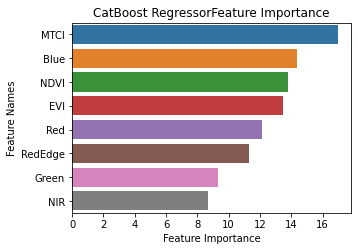

In [66]:
plot_feature_importance(model.get_feature_importance(type='FeatureImportance'),X_train.columns,'CatBoost Regressor')


,feature_names,feature_importance
6,MTCI,9.091935
5,NDVI,6.038425
1,Green,4.407378
7,EVI,4.404350
4,NIR,3.991189
2,Red,3.482992
3,RedEdge,2.965498
0,Blue,0.492910


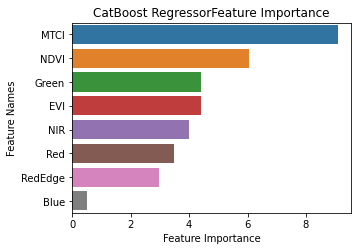

In [70]:
plot_feature_importance(model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="LossFunctionChange"),X_train.columns,'CatBoost Regressor')


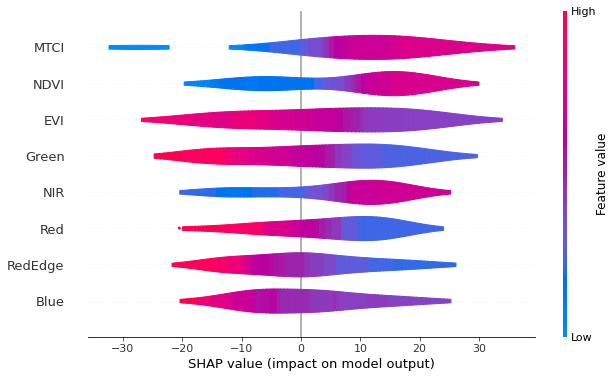

<Figure size 432x288 with 0 Axes>

In [101]:
import shap

# plot_feature_importance(model.get_feature_importance(Pool(X_test, label=y_test), 
#                                                                      type="LossFunctionChange"),X_train.columns,'CatBoost Regressor')


shap_values = model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
plt.clf()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])
shap.summary_plot(shap_values, X_test, plot_type='violin', plot_size=(10,6))
# plt.savefig('Data/shap.pdf',dpi=500, bbox_inches='tight')
plt.savefig("Data/shap.pdf", format='pdf', dpi=1000, bbox_inches='tight')

# shap_values

In [159]:
from catboost import CatBoostClassifier, Pool, cv

shap_values = model.get_feature_importance(Pool(X_test, label=y_test), 
                                                                     type="LossFunctionChange")
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]
shap_values
# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])


array([0.49291013, 4.40737832, 3.48299218, 2.96549773, 3.99118924,
       6.03842516, 9.09193508, 4.40435044])

In [167]:
import nltk
import catboost

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(catboost.__version__))

# The nltk version is 3.0.0.
# The scikit-learn version is 0.15.2.
import sys
print(sys.version)  # parentheses necessary in python 3.       


The nltk version is 3.5.
The scikit-learn version is 0.24.3.
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]




10 fold cross validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

model = Lasso(alpha= 4.5)

Standardized data used

alpha from 0.1 to 10 with in incremet of 0.1

max_iter didnt have an impact

R2{1: 0.6165133338737417}


model = RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1)

R2 {0.7359203255994402}

model = GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500)

R2 {0.7139824275506774}

model = CatBoostRegressor(depth=8)

R2{1: 0.7134514098951099}
